In [3]:
import json
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image
import random
import subprocess
from pagexml.parser import parse_pagexml_file
from pagexml.model.pagexml_document_model import PageXMLTextLine, PageXMLTextRegion
import sys
from shutil import copy
from dotenv import dotenv_values

PROJECT_DIR = Path.cwd().parent
sys.path.append(str(PROJECT_DIR))


dotenv_dict = dotenv_values(PROJECT_DIR / ".env")
DATA_DIR = Path(dotenv_dict["POLIS_DATA_DIR"])



In [2]:
# Helpers
def random_color():
    return (random.random(), random.random(), random.random())  # RGBA with transparency


def show_image(image_masks: list[dict], image_path: str, size: int=10):
    file_name = Path(image_path).name

    colors = [random_color() for _ in range(len(image_masks))]

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(size, size))

    # Show the image
    image = Image.open(image_path)
    ax.imshow(image)

    # Draw the bounding box
    for idx, ann in enumerate(image_masks):
        bbox = ann["bbox"]
        segm = ann["segmentation"][0]
        rect = patches.Rectangle(
            (bbox[0], bbox[1]), bbox[2], bbox[3],
            linewidth=2, edgecolor='lime', facecolor='none', label="Bounding Box"
        )
        ax.add_patch(rect)
        ax.text(bbox[0], bbox[1] - 10, str(idx), color = "lime", size=11)

        # Draw the segmentation mask
        seg_x = segm[0::2]
        seg_y = segm[1::2]
        ax.fill(seg_x, seg_y, facecolor=colors[idx], alpha=0.4, edgecolor=colors[idx], linewidth=2, label="Segmentation")

    # Set axis limits
    ax.set_xlim(0, image.width)
    ax.set_ylim(image.height, 0)  # Invert y-axis to match image coordinates

    # Labels and legend
    ax.set_title(file_name)
    # ax.legend()

    # Show the plot
    plt.show()

# Poliskammare

In [8]:
def merge_lines_to_regions(line_list: list[PageXMLTextLine]):

    # Upper bound points: select upper points of the first line. Select until the point start to go back
    upper_bound = []
    max_x = 0
    for point in reversed(line_list[0].coords.points):
        if point[0] > max_x:
            upper_bound.append(point)
            max_x = point[0]
    
    upper_bound = list(reversed(upper_bound))

    # lower bound points: select lower points of the last line
    lower_bound = []
    max_x = 0
    for point in line_list[-1].coords.points:
        if point[0] > max_x:
            lower_bound.append(point)
            max_x = point[0]
        else:
            break
    
    
    # Right bound: For each line, select n rightmost point
    n_candidates = 2
    right_bound = []
    for line in reversed(line_list):
        ordered_points = sorted(line.coords.points, key= lambda x: x[0], reverse=True)
        rightmost_candidates = sorted(ordered_points[:n_candidates], key = lambda x: x[1], reverse=True)
        right_bound += rightmost_candidates
        

    # Left bound: for each line, select n leftmost point
    left_bound = []
    for line in line_list:
        ordered_points = sorted(line.coords.points, key= lambda x: x[0], reverse=False)
        leftmost_candidates = sorted(ordered_points[:n_candidates], key = lambda x: x[1], reverse=False)
        left_bound += leftmost_candidates
    
    
    # Construct region poly: points go in counter-clockwise , starting from lower bound
    region_poly = lower_bound + right_bound + upper_bound + left_bound
    
    return region_poly

        

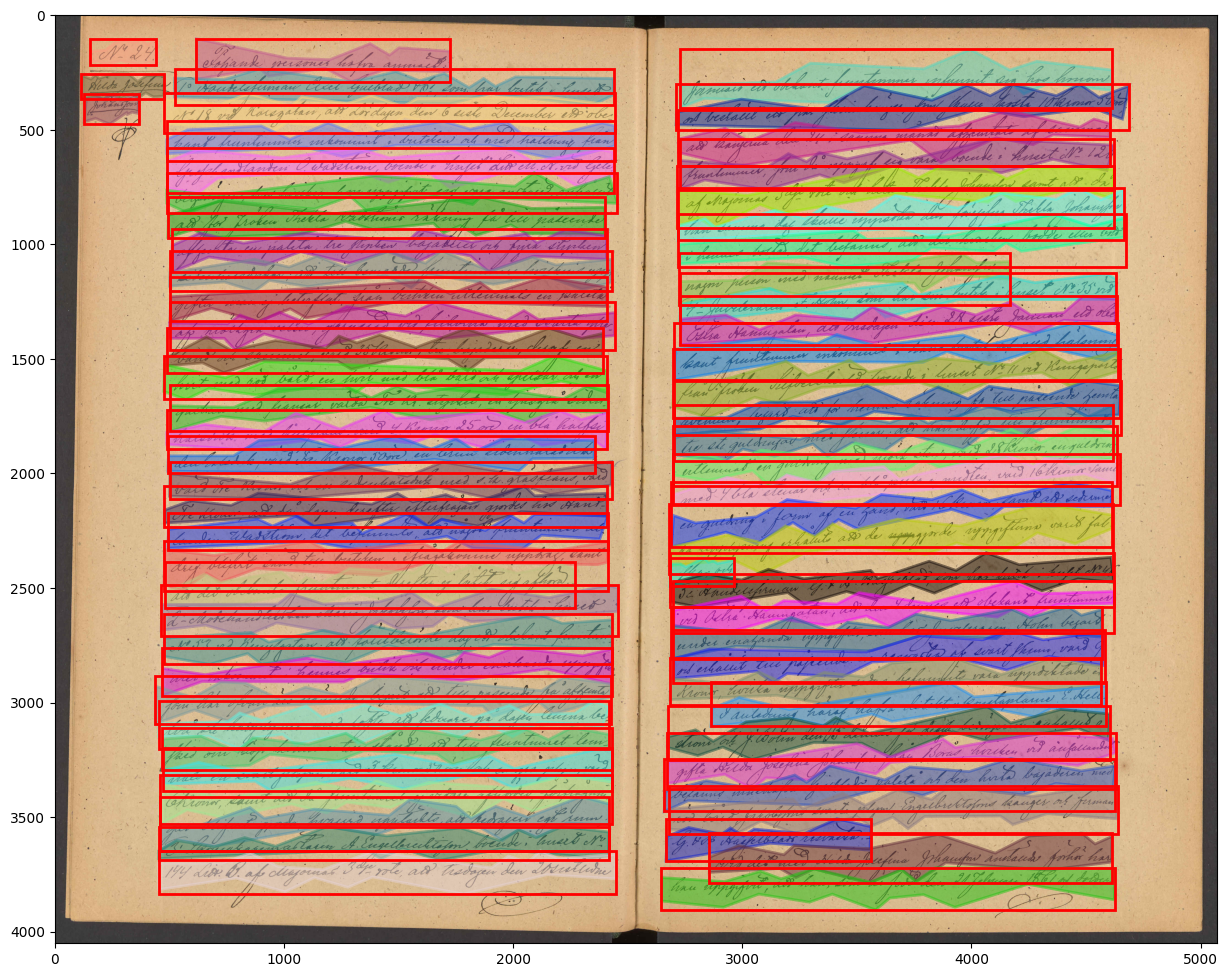

In [ ]:
# Visualize poliskammare

file_idx = 20

image_files = sorted(DATA_DIR.glob(pattern="images/**/*.tif"))
xml_files = sorted(DATA_DIR.glob(pattern="page_xmls/**/*.xml"))

image_path = image_files[file_idx]
xml_path = xml_files[file_idx]


def construct_line_bbox(line: PageXMLTextLine):
    seg_x = [x for (x, y) in line.coords.points]
    seg_y = [y for (x, y) in line.coords.points]
    anchor_x = min(seg_x)
    anchor_y =  min(seg_y)
    width = max(seg_x) - min(seg_x)
    height = max(seg_y) - min(seg_y)

    return anchor_x, anchor_y, width, height


def show_poliskammare_img(image_path: str, xml_path: str, show_large_bbox=False, show_line_bbox=True, fig_size=15):

    # Get data
    content = parse_pagexml_file(xml_path)
    region_data = content.get_regions()
    line_data = content.get_lines()


    # Show image
    fig, ax = plt.subplots(figsize=(fig_size, fig_size))
    image = Image.open(image_path)
    ax.imshow(image)


    # Color for lines
    line_colors = [random_color() for _ in range(len(line_data))]

    if show_large_bbox:
        # Draw bbox for each large region
        for idx, region in enumerate(region_data):
            bbox = region.coords.points

            # bbox is not guaranteed to be a rectangle, and can actually be of weird shapes
            rect = patches.Polygon(
                bbox,
                linewidth=2, edgecolor='r', facecolor='none', label="Bounding Box"
            )
            ax.add_patch(rect)


    # Color lines
    for idx, poly in enumerate(line_data):
        seg_x = [x for (x, y) in poly.coords.points]
        seg_y = [y for (x, y) in poly.coords.points]
        ax.fill(
            seg_x, seg_y, 
            facecolor=line_colors[idx], 
            alpha=0.5, 
            edgecolor=line_colors[idx], 
            linewidth=2, label="Segmentation"
        )


    if show_line_bbox:
        # Construct bbox for each line
        for idx, region in enumerate(region_data):
            region_lines = region.get_lines()
            
            for idx, poly in enumerate(region_lines):
                anchor_x, anchor_y, width, height = construct_line_bbox(poly)

                rect = patches.Rectangle(
                    (anchor_x, anchor_y), width, height,
                    linewidth=2, edgecolor='r', facecolor='none', label="Bounding Box"
                )
                ax.add_patch(rect)


show_poliskammare_img(image_path, xml_path)


In [10]:
xml_data = parse_pagexml_file(xml_path)

region_chars_limit = 1024

line_groups = []

current_lines = []
current_length = 0

for line_data in xml_data.get_lines():
    if line_data.text is not None or line_data.text > 0:
        if current_length + len(line_data.text) <= region_chars_limit:
            current_lines.append(line_data)
            current_length += len(line_data.text)
        else:
            line_groups.append(current_lines)
            current_lines = []
            current_length = 0


In [ ]:
def merge_lines_to_regions(line_list: list[PageXMLTextLine]):
    # Need to dedup points as well

    # lower bound points: select lower points of the last line. 
    lower_bound = []
    max_x = 0
    for point in line_list[-1].coords.points:
        if point[0] > max_x:
            lower_bound.append(point)
            max_x = point[0]
        else:
            break
    
    # If the next-last line is longer than the last line, then select some points of the next-last line
    for point in line_list[-2].coords.points:
        if point[0] >= lower_bound[-1][0]:
            lower_bound.append(point)
            max_x = point[0]
        else:
            break
    
    # Right bound: For each line, select n rightmost point
    n_candidates = 2
    right_bound = []
    max_x = 0
    for idx, line in enumerate(reversed(line_list)):
        # sort points by x to get the top n x-farthest points
        ordered_points = sorted(line.coords.points, key= lambda x: x[0], reverse=True)

        # Picking n candidates, sort them from bottom to top
        rightmost_candidates = sorted(ordered_points[:n_candidates], key = lambda x: x[1], reverse=True)
        

        # If the first line is shorter than the second line, add points of the second line
        second_last_line = reversed(line_list)[idx-1]
        if idx == len(line_list):
            if max([x[0] for x in line]) < max([x[0] for x in second_last_line]):
                top_right_corner_idx = list(second_last_line.coords.points).index(rightmost_candidates[-1])
                for point in second_last_line[top_right_corner_idx:]:
                    if point[0] >= max([x[0] for x in line]):
                        right_bound.append(point)
                    


        right_bound += rightmost_candidates
        
    

    # Upper bound points: select upper points of the first line. Select until the point start to go back
    upper_bound = []
    max_x = 0
    for point in reversed(line_list[0].coords.points):
        if point[0] > max_x:
            upper_bound.append(point)
            max_x = point[0]
    
    upper_bound = list(reversed(upper_bound))

    
    
        

    # Left bound: for each line, select n leftmost point
    left_bound = []
    for line in line_list:
        ordered_points = sorted(line.coords.points, key= lambda x: x[0], reverse=False)
        leftmost_candidates = sorted(ordered_points[:n_candidates], key = lambda x: x[1], reverse=False)
        left_bound += leftmost_candidates
    
    
    # Construct region poly: points go in counter-clockwise , starting from lower bound
    region_poly = lower_bound + right_bound + upper_bound + left_bound
    
    return region_poly

        

masks = []
transcriptions = []

def join_transcriptions(line_list: list[PageXMLTextLine]):
    texts = []
    for line in line_list:
        if line.text:
            texts.append(line.text)
    
    return "\n".join(texts)

for group in line_groups:
    mask = merge_lines_to_regions(group)
    trans = join_transcriptions(group)
    masks.append(mask)
    transcriptions.append(trans)



def show_masks(image_path: str, masks: list[list[tuple]], fig_size=15):

    # Show image
    fig, ax = plt.subplots(figsize=(fig_size, fig_size))
    image = Image.open(image_path)
    ax.imshow(image)


    # Color for lines
    line_colors = [random_color() for _ in range(len(masks))]


    # Color lines
    for idx, poly in enumerate(masks):
        seg_x = [x for (x, y) in poly]
        seg_y = [y for (x, y) in poly]
        ax.fill(
            seg_x, seg_y, 
            facecolor=line_colors[idx], 
            alpha=0.5, 
            edgecolor=line_colors[idx], 
            linewidth=2, label="Segmentation"
        )

show_masks(image_path, masks)